<a href="https://colab.research.google.com/github/Akshatpattiwar512/Convolutional-Neural-Network/blob/main/Sign_Language_Translation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download datamunge/sign-language-mnist

sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
print(os.listdir("../content"))

['.config', 'sign_mnist_train.csv', 'sign_mnist_train', 'amer_sign3.png', 'amer_sign2.png', 'sign_mnist_test.csv', 'american_sign_language.PNG', 'sign_mnist_test', 'kaggle.json', 'sign-language-mnist.zip', '.ipynb_checkpoints', 'sample_data']


## Exploratory Data Analysis of Training Data

In [3]:
data = pd.read_csv('../content/sign_mnist_train.csv')
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [4]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [5]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 27455
Number of pixels in each image: 784


In [6]:
y = data.iloc[:, :1].values.flatten()
print('Labels:\n', y)
print('Shape of Labels:', y.shape)

Labels:
 [ 3  6  2 ... 18 17 23]
Shape of Labels: (27455,)


In [7]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [8]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

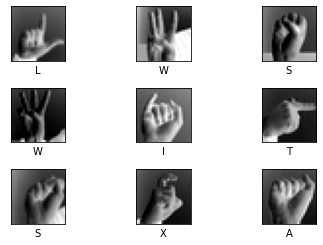

In [9]:
display_images(next_batch(9, x, y))

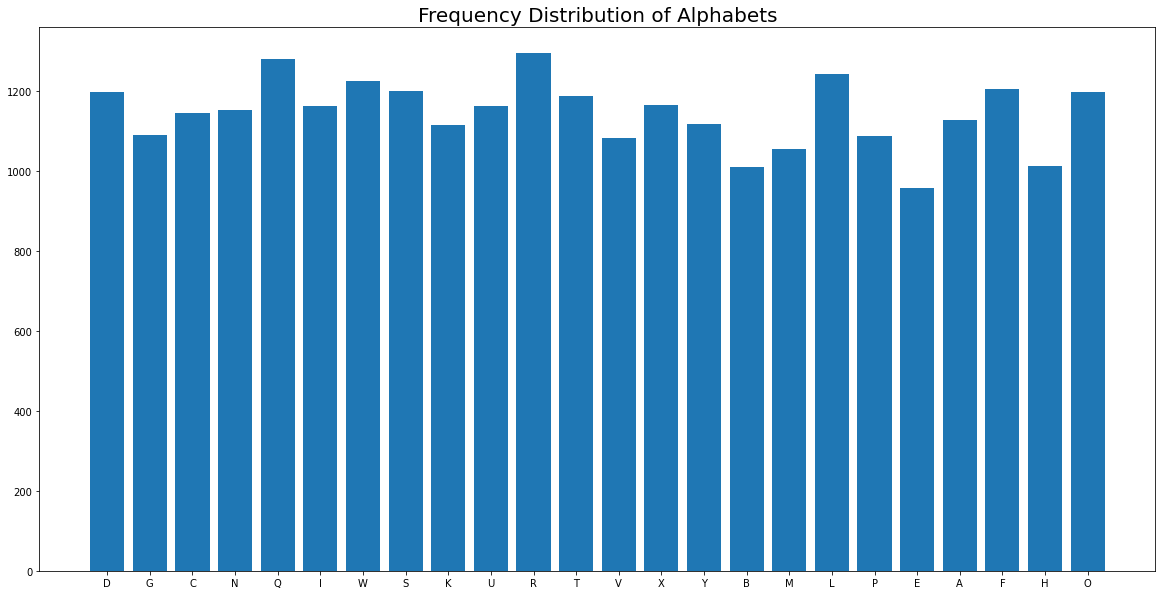

In [10]:
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
labels = [chr(i + 65) for i in z.keys()]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Alphabets', fontsize = 20)
plt.show()

### One Hot Encoding

In [11]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (27455, 25)


## Convolutional Neural Network - Model Building

In [12]:
# Training Parameters
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100

In [13]:
# Neural Network Hyperparameters
n_input = 784
n_classes = 25
dropout = 0.75

In [14]:
# Disabling Eager Execution
tf.compat.v1.disable_eager_execution()

In [15]:
# Placeholders
X = tf.compat.v1.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.compat.v1.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.compat.v1.placeholder(tf.float32) # Placeholder for Dropout Rate

In [16]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random.normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random.normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random.normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random.normal([1024, n_classes]))
}

In [17]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random.normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random.normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random.normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random.normal([n_classes]))
}

In [18]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [19]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [20]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [21]:
logits = neural_network(X, weights, biases, keep_prob)

In [23]:
loss_op = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [24]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [25]:
init = tf.compat.v1.global_variables_initializer()

In [26]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (18394, 784)
y train shape (18394, 25)
X test shape (9061, 784)
y test shape (9061, 25)


In [27]:
with tf.compat.v1.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
 #       sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

Epoch 100, Cost: nan, Accuracy: 3.90625 %
Epoch 200, Cost: nan, Accuracy: 0.78125 %
Epoch 300, Cost: nan, Accuracy: 3.125 %
Epoch 400, Cost: nan, Accuracy: 3.90625 %
Epoch 500, Cost: nan, Accuracy: 5.46875 %
Epoch 600, Cost: nan, Accuracy: 3.125 %
Epoch 700, Cost: nan, Accuracy: 2.34375 %
Epoch 800, Cost: nan, Accuracy: 2.34375 %
Epoch 900, Cost: nan, Accuracy: 3.90625 %
Epoch 1000, Cost: nan, Accuracy: 4.6875 %
Epoch 1100, Cost: nan, Accuracy: 1.5625 %
Epoch 1200, Cost: nan, Accuracy: 3.125 %
Epoch 1300, Cost: nan, Accuracy: 3.90625 %
Epoch 1400, Cost: nan, Accuracy: 4.6875 %
Epoch 1500, Cost: nan, Accuracy: 3.90625 %
Epoch 1600, Cost: nan, Accuracy: 2.34375 %
Epoch 1700, Cost: nan, Accuracy: 3.90625 %
Epoch 1800, Cost: nan, Accuracy: 3.90625 %
Epoch 1900, Cost: nan, Accuracy: 3.90625 %
Epoch 2000, Cost: nan, Accuracy: 3.90625 %
--------------------------------------------------

Optimization Finished

Accuracy on Training Data: 4.1970208287239075 %
Accuracy on Test Data: 3.9068534970

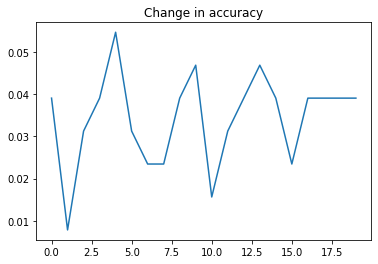

In [29]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()